# XOM 7-2-1

**DATA PREPARATION**



*   Import Packages



In [47]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense, GRU



*   Read data from a CSV file



In [48]:
data = pd.read_csv('/content/XOM.csv')

In [49]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,83.820000,85.199997,83.660004,85.029999,64.879845,11469300
1,2018-01-03,85.160004,86.970001,84.820000,86.699997,66.154083,13957700
2,2018-01-04,86.790001,87.220001,86.430000,86.820000,66.245667,10863000
3,2018-01-05,86.750000,86.879997,85.709999,86.750000,66.192230,11047600
4,2018-01-08,86.699997,87.150002,86.599998,87.139999,66.489830,10927100




*   Visualize the stock price history


Text(0, 0.5, 'Prices ($)')

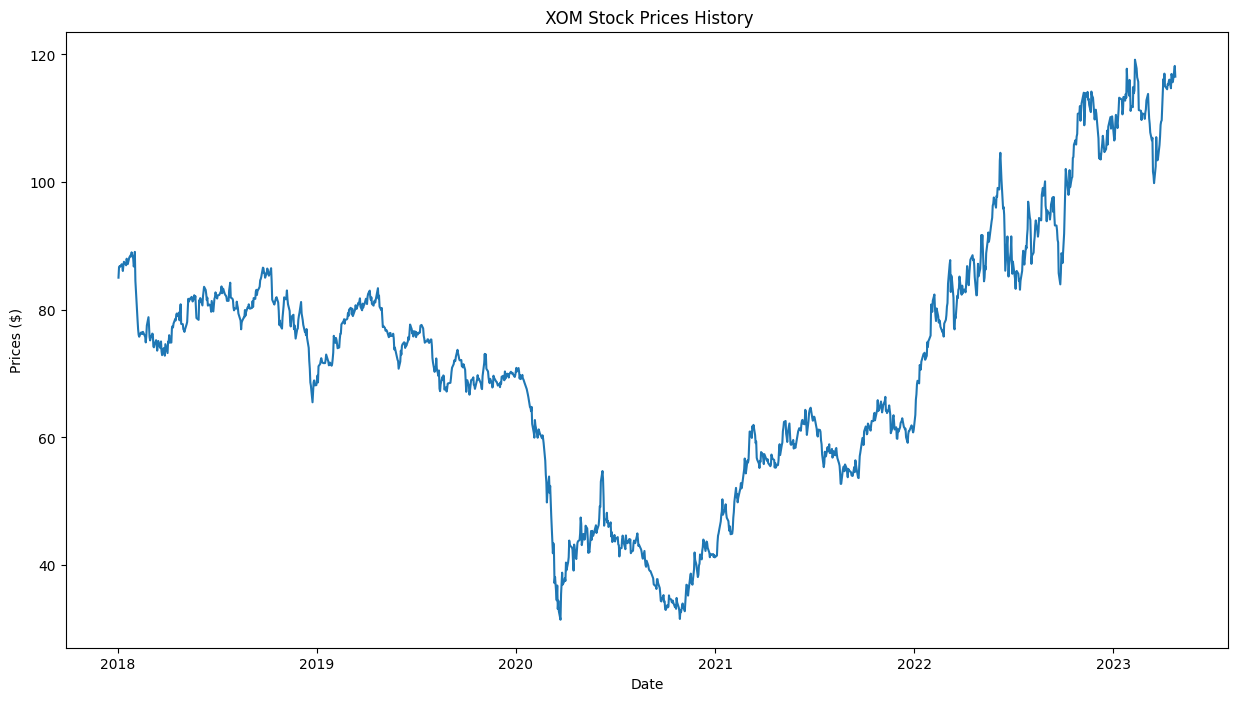

In [50]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

plt.figure(figsize=(15, 8))
plt.title(' XOM Stock Prices History')
plt.plot(data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

**DATA PREPROCESSING**



*   Normalize data using the MinMaxScaler method




In [51]:
close_prices = data['Close']
values = close_prices.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))



*   Split data into train, test, and validation sets with a ratio of 7:2:1




In [52]:
train_size = int(len(scaled_data) * 0.7)
test_size = int(len(scaled_data) * 0.2)
val_size = len(scaled_data) - train_size - test_size

time_step = 60
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size-time_step:train_size+test_size, :]
val_data = scaled_data[train_size+test_size-time_step:, :]

In [53]:
print("Dataset size: ", len(values), "\n")

print("Train size: ", train_size)
print("Test size: ", test_size)
print("Valate size: ", val_size)

Dataset size:  1337 

Train size:  935
Test size:  267
Valate size:  135




*   Define the Create Dataset function


In [54]:
def create_dataset(dataset, time_step):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----59   Y=60
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)



*   Create train, test, and validation datasets



In [55]:
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)



*   Reshape train, test, and validation data (required for LSTM)



In [56]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

**BUILD GRU MODEL**

In [57]:
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [58]:
model.fit(X_train,y_train,epochs=50,batch_size=32,verbose=1)

Epoch 1/50
28/28 [==============================] - 2s 24ms/step - loss: 0.0248
Epoch 2/50
28/28 [==============================] - 1s 28ms/step - loss: 0.0031
Epoch 3/50
28/28 [==============================] - 1s 27ms/step - loss: 7.6203e-04
Epoch 4/50
28/28 [==============================] - 1s 21ms/step - loss: 3.4734e-04
Epoch 5/50
28/28 [==============================] - 1s 20ms/step - loss: 3.3937e-04
Epoch 6/50
28/28 [==============================] - 1s 20ms/step - loss: 3.2140e-04
Epoch 7/50
28/28 [==============================] - 1s 20ms/step - loss: 3.1302e-04
Epoch 8/50
28/28 [==============================] - 1s 20ms/step - loss: 3.0414e-04
Epoch 9/50
28/28 [==============================] - 1s 20ms/step - loss: 2.9420e-04
Epoch 10/50
28/28 [==============================] - 1s 19ms/step - loss: 2.9201e-04
Epoch 11/50
28/28 [==============================] - 1s 20ms/step - loss: 2.8162e-04
Epoch 12/50
28/28 [==============================] - 1s 20ms/step - loss: 2.7326e-



*   PLotting loss, it shows that loss has decreased significantly and model trained well



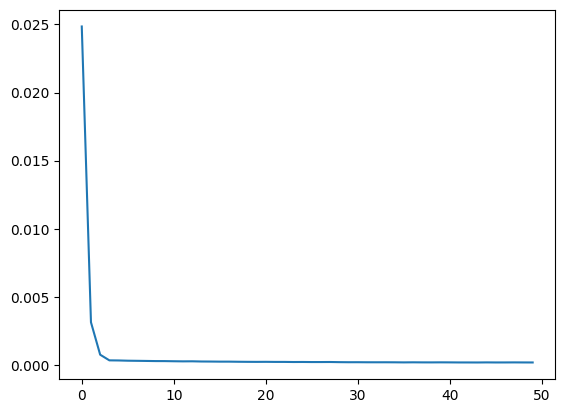

In [59]:
loss = model.history.history['loss']
plt.plot(loss)

**PREDICTION AND EVALUATION ON TEST/VAL DATA**



*   Make predictions on test and validation data



In [60]:
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

5/5 [==============================] - 0s 5ms/step




*   Convert the predictions back to the original values



In [61]:
y_pred=scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

y_pred_val=scaler.inverse_transform(y_pred_val)
y_val = scaler.inverse_transform(y_val.reshape(-1, 1))



*   Evaluate the algorithm's accuracy using RMSE, MAPE, MDA



In [62]:
# MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Using RMSE, MAPE và MDA
valid_rmse = np.sqrt(np.mean((y_val- y_pred_val) ** 2))
test_rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))

valid_mape = calculate_mape(y_val, y_pred_val)
test_mape = calculate_mape(y_test, y_pred)

valid_mda = calculate_mda(np.squeeze(y_val), np.squeeze(y_pred_val)) # Squeeze y_val and y_pred_val to 1D arrays
test_mda = calculate_mda(np.squeeze(y_test), np.squeeze(y_pred)) # Squeeze y_test and y_pred to 1D arrays

# Print results
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
print('Validation MDA:', valid_mda)
print('Testing MDA:', test_mda)

Validation RMSE: 1.9572601297553616
Testing RMSE: 1.9426238592703229
Validation MAPE: 1.3500334730055121
Testing MAPE: 1.820938594749619
Validation MDA: 49.25373134328358
Testing MDA: 54.88721804511278


**FORECAST FOR THE NEXT 30 DAYS IN THE FUTURE**

In [63]:
n_days = 30

x_input=scaled_data[-time_step:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
i=0
while(i<n_days):

    if(len(temp_input)>time_step):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, time_step,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.97890705]
61
1 day input [0.96397633 0.9494984  0.90857277 0.91735066 0.91518473 0.95155039
 0.94015048 0.94505244 1.         0.98438218 0.96865025 0.9646603
 0.96078437 0.91005473 0.90880073 0.89238491 0.90389877 0.90401279
 0.90173284 0.89443691 0.90560876 0.91142275 0.92749658 0.93889649
 0.91381672 0.89523489 0.8855449  0.87015505 0.85601918 0.86057916
 0.79993165 0.79320566 0.77963973 0.80939351 0.86171914 0.8337893
 0.8203375  0.82170543 0.84758327 0.86263115 0.88360694 0.88964888
 0.89158693 0.96534426 0.95269037 0.9751482  0.95303243 0.94721845
 0.95645235 0.95508441 0.9612403  0.96443234 0.94904239 0.97457825
 0.97036026 0.95975833 0.96397633 0.98894208 0.96979023 0.97890705]
1 day output [[0.98261154]]
2 day input [0.9494984  0.90857277 0.91735066 0.91518473 0.95155039 0.94015048
 0.94505244 1.         0.98438218 0.96865025 0.9646603  0.96078437
 0.91005473 0.90880073 0.89238491 0.90389877 0.90401279 0.90173284
 0.89443691 0.90560876 0.91142275 0.92749658 0.93889649 0.9138



*   List of predicted stock prices for the next 30 days



In [64]:
for i in range(1, n_days+1):
    print(f"Ngày thứ {i}: {scaler.inverse_transform(lst_output)[i-1]}")
    # scaler.inverse_transform(lst_output)

Ngày thứ 1: [117.31972438]
Ngày thứ 2: [117.64468208]
Ngày thứ 3: [117.99294852]
Ngày thứ 4: [118.34986293]
Ngày thứ 5: [118.71308293]
Ngày thứ 6: [119.08068966]
Ngày thứ 7: [119.45195113]
Ngày thứ 8: [119.82680459]
Ngày thứ 9: [120.20469059]
Ngày thứ 10: [120.58547319]
Ngày thứ 11: [120.96970661]
Ngày thứ 12: [121.35706669]
Ngày thứ 13: [121.74746977]
Ngày thứ 14: [122.14109361]
Ngày thứ 15: [122.53800097]
Ngày thứ 16: [122.93764807]
Ngày thứ 17: [123.34012902]
Ngày thứ 18: [123.74515104]
Ngày thứ 19: [124.15286051]
Ngày thứ 20: [124.56318425]
Ngày thứ 21: [124.9759863]
Ngày thứ 22: [125.39107844]
Ngày thứ 23: [125.80847114]
Ngày thứ 24: [126.22809118]
Ngày thứ 25: [126.65022091]
Ngày thứ 26: [127.07507993]
Ngày thứ 27: [127.50242772]
Ngày thứ 28: [127.93225383]
Ngày thứ 29: [128.36461055]
Ngày thứ 30: [128.79943512]


**VISUALIZATION OF PREDICTIONS**



*   Plot 1



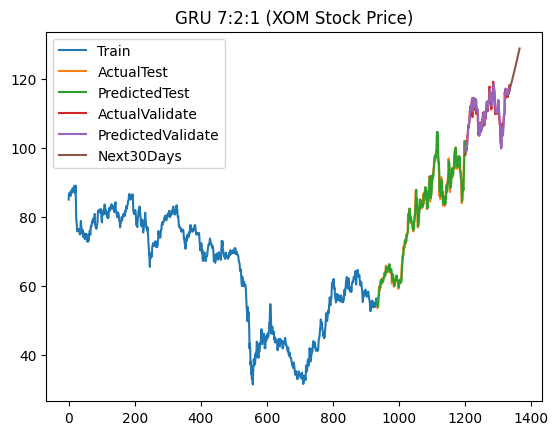

In [65]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
prediect_data_index = pd.RangeIndex(start=len(close_prices), stop=len(close_prices)+n_days, step=1)

plt.plot(scaler.inverse_transform(train_data))

plt.plot(test_data_index,y_test)
plt.plot(test_data_index,y_pred)

plt.plot(val_data_index,y_val)
plt.plot(val_data_index,y_pred_val)

plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.title('GRU 7:2:1 (XOM Stock Price)')
plt.legend(['Train','ActualTest','PredictedTest','ActualValidate','PredictedValidate','Next30Days'])
plt.show()



*   Plot 2



In [66]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data_index, y=scaler.inverse_transform(train_data)[:, 0], mode='lines+markers', marker=dict(size=4),  name='Train', marker_color='#1F77B4'))
fig.add_trace(go.Scatter(x=test_data_index,y=y_test[:, 0], mode='lines+markers', marker=dict(size=4), name='ActualTest', marker_color='#FF7F0E'))
fig.add_trace(go.Scatter(x=test_data_index,y=y_pred[:, 0], mode='lines+markers', marker=dict(size=4), name='PredictedTest', marker_color='#2CA02C'))
fig.add_trace(go.Scatter(x=val_data_index, y=y_val[:, 0], mode='lines+markers', marker=dict(size=4), name='ActualValidate', marker_color='#D62728'))
fig.add_trace(go.Scatter(x=val_data_index, y=y_pred_val[:, 0], mode='lines+markers', marker=dict(size=4), name='PredictedValidate', marker_color='#9569BE'))
fig.add_trace(go.Scatter(x=prediect_data_index, y=scaler.inverse_transform(lst_output)[:, 0], mode='lines+markers', marker=dict(size=4), name='Next30Days', marker_color='#000000'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'GRU 7:2:1 (XOM Stock Price)', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()



*   Plot 3



In [67]:
prediect_index = pd.RangeIndex(start=1, stop=1+n_days, step=1)

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=prediect_index, y=scaler.inverse_transform(lst_output)[:, 0], mode='lines+markers', marker=dict(size=4), name='Next30Days', marker_color='#FF7F0E'))
for i in range(len(prediect_index)):
  fig2.add_annotation(
      x=prediect_index[i],
      y=scaler.inverse_transform(lst_output)[i, 0],
      text=f"{scaler.inverse_transform(lst_output)[i, 0]:.2f}",
      showarrow=False,
      font=dict(color='black'),
      align='center',
      yshift=10)

fig2.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'GRU Prediction 7:2:1 (XOM Stock Price)', title_x = 0.5,
                  xaxis_title="Day",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig2.show()

# XOM 6-2-2

**DATA PREPARATION**



*   Import Packages



In [68]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense, GRU



*   Read data from a CSV file



In [69]:
data = pd.read_csv('/content/XOM.csv')

In [70]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,83.820000,85.199997,83.660004,85.029999,64.879845,11469300
1,2018-01-03,85.160004,86.970001,84.820000,86.699997,66.154083,13957700
2,2018-01-04,86.790001,87.220001,86.430000,86.820000,66.245667,10863000
3,2018-01-05,86.750000,86.879997,85.709999,86.750000,66.192230,11047600
4,2018-01-08,86.699997,87.150002,86.599998,87.139999,66.489830,10927100




*   Visualize the stock price history


Text(0, 0.5, 'Prices ($)')

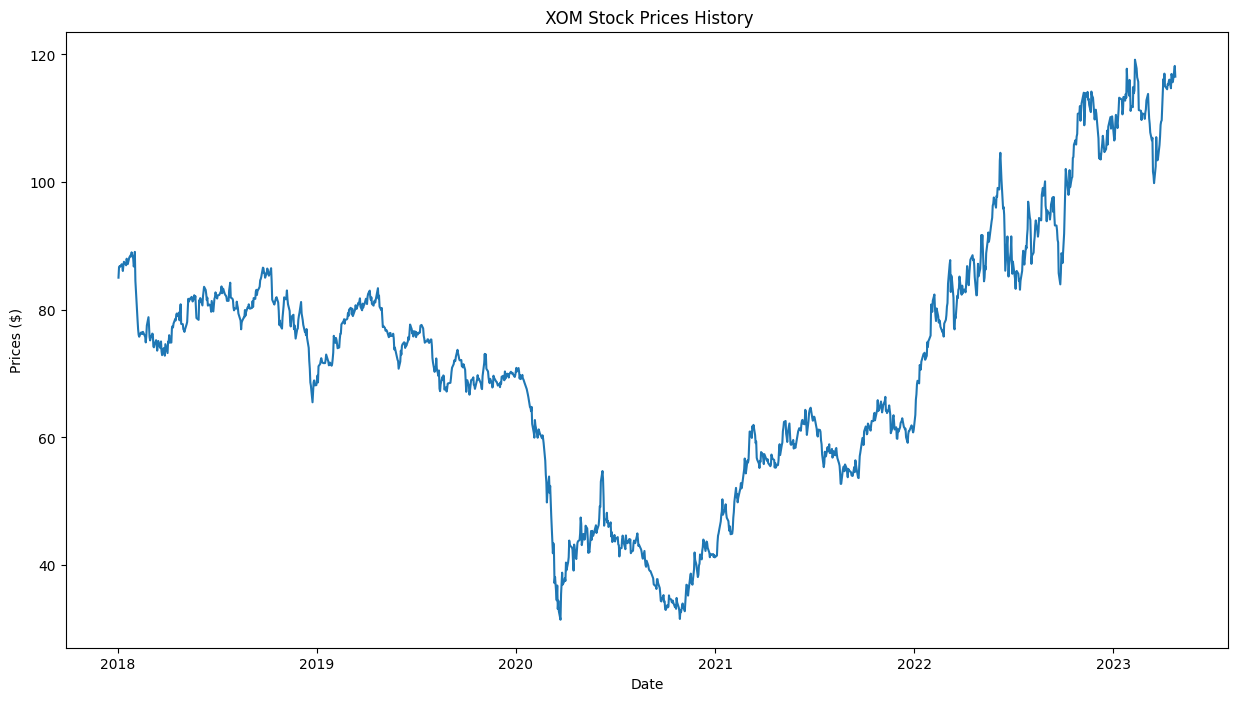

In [71]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

plt.figure(figsize=(15, 8))
plt.title(' XOM Stock Prices History')
plt.plot(data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

**DATA PREPROCESSING**



*   Normalize data using the MinMaxScaler method




In [72]:
close_prices = data['Close']
values = close_prices.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))



*   Split data into train, test, and validation sets with a ratio of 6:2:2




In [73]:
train_size = int(len(scaled_data) * 0.6)
test_size = int(len(scaled_data) * 0.2)
val_size = len(scaled_data) - train_size - test_size

time_step = 60
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size-time_step:train_size+test_size, :]
val_data = scaled_data[train_size+test_size-time_step:, :]

In [74]:
print("Dataset size: ", len(values), "\n")

print("Train size: ", train_size)
print("Test size: ", test_size)
print("Valate size: ", val_size)

Dataset size:  1337 

Train size:  802
Test size:  267
Valate size:  268




*   Define the Create Dataset function


In [75]:
def create_dataset(dataset, time_step):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----59   Y=60
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)



*   Create train, test, and validation datasets



In [76]:
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)



*   Reshape train, test, and validation data (required for LSTM)



In [77]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

**BUILD GRU MODEL**

In [78]:
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [79]:
model.fit(X_train,y_train,epochs=50,batch_size=32,verbose=1)

Epoch 1/50
24/24 [==============================] - 2s 21ms/step - loss: 0.0152
Epoch 2/50
24/24 [==============================] - 0s 20ms/step - loss: 0.0024
Epoch 3/50
24/24 [==============================] - 0s 20ms/step - loss: 6.1423e-04
Epoch 4/50
24/24 [==============================] - 1s 24ms/step - loss: 3.2213e-04
Epoch 5/50
24/24 [==============================] - 1s 28ms/step - loss: 3.0933e-04
Epoch 6/50
24/24 [==============================] - 1s 28ms/step - loss: 2.9164e-04
Epoch 7/50
24/24 [==============================] - 1s 22ms/step - loss: 2.8799e-04
Epoch 8/50
24/24 [==============================] - 0s 20ms/step - loss: 2.9612e-04
Epoch 9/50
24/24 [==============================] - 0s 20ms/step - loss: 2.7877e-04
Epoch 10/50
24/24 [==============================] - 1s 21ms/step - loss: 2.7712e-04
Epoch 11/50
24/24 [==============================] - 0s 20ms/step - loss: 2.7284e-04
Epoch 12/50
24/24 [==============================] - 0s 21ms/step - loss: 2.5808e-



*   PLotting loss, it shows that loss has decreased significantly and model trained well



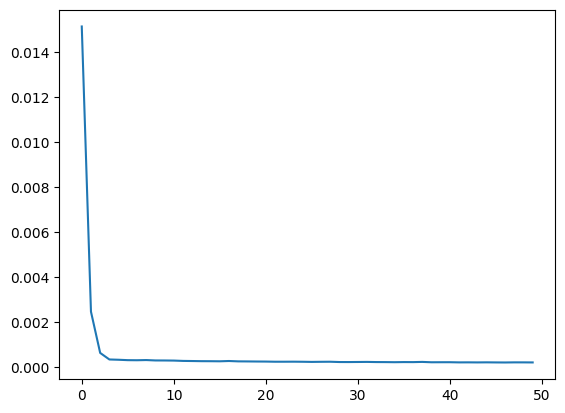

In [80]:
loss = model.history.history['loss']
plt.plot(loss)

**PREDICTION AND EVALUATION ON TEST/VAL DATA**



*   Make predictions on test and validation data



In [81]:
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

9/9 [==============================] - 0s 5ms/step




*   Convert the predictions back to the original values



In [82]:
y_pred=scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

y_pred_val=scaler.inverse_transform(y_pred_val)
y_val = scaler.inverse_transform(y_val.reshape(-1, 1))



*   Evaluate the algorithm's accuracy using RMSE, MAPE, MDA



In [83]:
# MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Using RMSE, MAPE và MDA
valid_rmse = np.sqrt(np.mean((y_val- y_pred_val) ** 2))
test_rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))

valid_mape = calculate_mape(y_val, y_pred_val)
test_mape = calculate_mape(y_test, y_pred)

valid_mda = calculate_mda(np.squeeze(y_val), np.squeeze(y_pred_val)) # Squeeze y_val and y_pred_val to 1D arrays
test_mda = calculate_mda(np.squeeze(y_test), np.squeeze(y_pred)) # Squeeze y_test and y_pred to 1D arrays

# Print results
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
print('Validation MDA:', valid_mda)
print('Testing MDA:', test_mda)

Validation RMSE: 2.200906050947486
Testing RMSE: 1.3241784387389963
Validation MAPE: 1.7552571634439698
Testing MAPE: 1.5725632095687951
Validation MDA: 51.68539325842697
Testing MDA: 50.75187969924813


**FORECAST FOR THE NEXT 30 DAYS IN THE FUTURE**

In [84]:
n_days = 30

x_input=scaled_data[-time_step:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
i=0
while(i<n_days):

    if(len(temp_input)>time_step):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, time_step,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.9656842]
61
1 day input [0.96397633 0.9494984  0.90857277 0.91735066 0.91518473 0.95155039
 0.94015048 0.94505244 1.         0.98438218 0.96865025 0.9646603
 0.96078437 0.91005473 0.90880073 0.89238491 0.90389877 0.90401279
 0.90173284 0.89443691 0.90560876 0.91142275 0.92749658 0.93889649
 0.91381672 0.89523489 0.8855449  0.87015505 0.85601918 0.86057916
 0.79993165 0.79320566 0.77963973 0.80939351 0.86171914 0.8337893
 0.8203375  0.82170543 0.84758327 0.86263115 0.88360694 0.88964888
 0.89158693 0.96534426 0.95269037 0.9751482  0.95303243 0.94721845
 0.95645235 0.95508441 0.9612403  0.96443234 0.94904239 0.97457825
 0.97036026 0.95975833 0.96397633 0.98894208 0.96979023 0.96568418]
1 day output [[0.95947087]]
2 day input [0.9494984  0.90857277 0.91735066 0.91518473 0.95155039 0.94015048
 0.94505244 1.         0.98438218 0.96865025 0.9646603  0.96078437
 0.91005473 0.90880073 0.89238491 0.90389877 0.90401279 0.90173284
 0.89443691 0.90560876 0.91142275 0.92749658 0.93889649 0.91381



*   List of predicted stock prices for the next 30 days



In [85]:
for i in range(1, n_days+1):
    print(f"Ngày thứ {i}: {scaler.inverse_transform(lst_output)[i-1]}")
    # scaler.inverse_transform(lst_output)

Ngày thứ 1: [116.15981398]
Ngày thứ 2: [115.61478267]
Ngày thứ 3: [115.04924511]
Ngày thứ 4: [114.46821546]
Ngày thứ 5: [113.87366484]
Ngày thứ 6: [113.26679584]
Ngày thứ 7: [112.64832998]
Ngày thứ 8: [112.01943846]
Ngày thứ 9: [111.38086372]
Ngày thứ 10: [110.73345278]
Ngày thứ 11: [110.07858074]
Ngày thứ 12: [109.417126]
Ngày thứ 13: [108.75002968]
Ngày thứ 14: [108.0783375]
Ngày thứ 15: [107.40313175]
Ngày thứ 16: [106.72508691]
Ngày thứ 17: [106.04514935]
Ngày thứ 18: [105.36401969]
Ngày thứ 19: [104.68260769]
Ngày thứ 20: [104.00169763]
Ngày thứ 21: [103.32204764]
Ngày thứ 22: [102.64427469]
Ngày thứ 23: [101.96908985]
Ngày thứ 24: [101.29709964]
Ngày thứ 25: [100.62901514]
Ngày thứ 26: [99.96557356]
Ngày thứ 27: [99.30726115]
Ngày thứ 28: [98.65454849]
Ngày thứ 29: [98.00800549]
Ngày thứ 30: [97.36805564]


**VISUALIZATION OF PREDICTIONS**



*   Plot 1



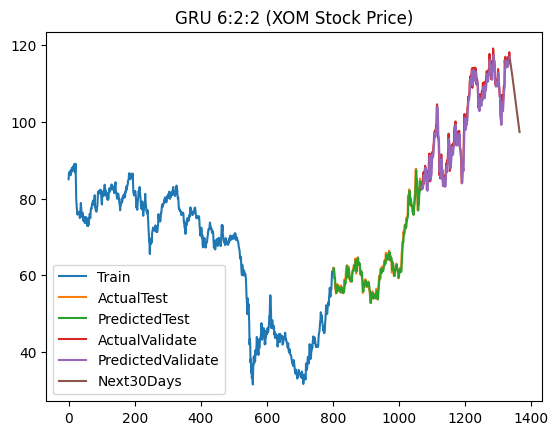

In [86]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
prediect_data_index = pd.RangeIndex(start=len(close_prices), stop=len(close_prices)+n_days, step=1)

plt.plot(scaler.inverse_transform(train_data))

plt.plot(test_data_index,y_test)
plt.plot(test_data_index,y_pred)

plt.plot(val_data_index,y_val)
plt.plot(val_data_index,y_pred_val)

plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.title('GRU 6:2:2 (XOM Stock Price)')
plt.legend(['Train','ActualTest','PredictedTest','ActualValidate','PredictedValidate','Next30Days'])
plt.show()



*   Plot 2



In [87]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data_index, y=scaler.inverse_transform(train_data)[:, 0], mode='lines+markers', marker=dict(size=4),  name='Train', marker_color='#1F77B4'))
fig.add_trace(go.Scatter(x=test_data_index,y=y_test[:, 0], mode='lines+markers', marker=dict(size=4), name='ActualTest', marker_color='#FF7F0E'))
fig.add_trace(go.Scatter(x=test_data_index,y=y_pred[:, 0], mode='lines+markers', marker=dict(size=4), name='PredictedTest', marker_color='#2CA02C'))
fig.add_trace(go.Scatter(x=val_data_index, y=y_val[:, 0], mode='lines+markers', marker=dict(size=4), name='ActualValidate', marker_color='#D62728'))
fig.add_trace(go.Scatter(x=val_data_index, y=y_pred_val[:, 0], mode='lines+markers', marker=dict(size=4), name='PredictedValidate', marker_color='#9569BE'))
fig.add_trace(go.Scatter(x=prediect_data_index, y=scaler.inverse_transform(lst_output)[:, 0], mode='lines+markers', marker=dict(size=4), name='Next30Days', marker_color='#000000'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'GRU 6:2:2 (XOM Stock Price)', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()



*   Plot 3



In [88]:
prediect_index = pd.RangeIndex(start=1, stop=1+n_days, step=1)

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=prediect_index, y=scaler.inverse_transform(lst_output)[:, 0], mode='lines+markers', marker=dict(size=4), name='Next30Days', marker_color='#FF7F0E'))
for i in range(len(prediect_index)):
  fig2.add_annotation(
      x=prediect_index[i],
      y=scaler.inverse_transform(lst_output)[i, 0],
      text=f"{scaler.inverse_transform(lst_output)[i, 0]:.2f}",
      showarrow=False,
      font=dict(color='black'),
      align='center',
      yshift=10)

fig2.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'GRU Prediction 6:2:2 (XOM Stock Price)', title_x = 0.5,
                  xaxis_title="Day",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig2.show()

# CVX 7-2-1

**DATA PREPARATION**



*   Import Packages



In [89]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense, GRU



*   Read data from a CSV file



In [90]:
data = pd.read_csv('/content/CVX.csv')

In [91]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,125.709999,127.739998,125.540001,127.580002,100.577354,5626000
1,2018-01-03,127.459999,128.940002,126.900002,128.509995,101.310501,5805500
2,2018-01-04,127.949997,128.350006,127.220001,128.110001,100.995163,4598300
3,2018-01-05,127.970001,128.100006,127.099998,127.900002,100.829620,4189200
4,2018-01-08,127.860001,128.630005,127.629997,128.529999,101.326271,4826100




*   Visualize the stock price history


Text(0, 0.5, 'Prices ($)')

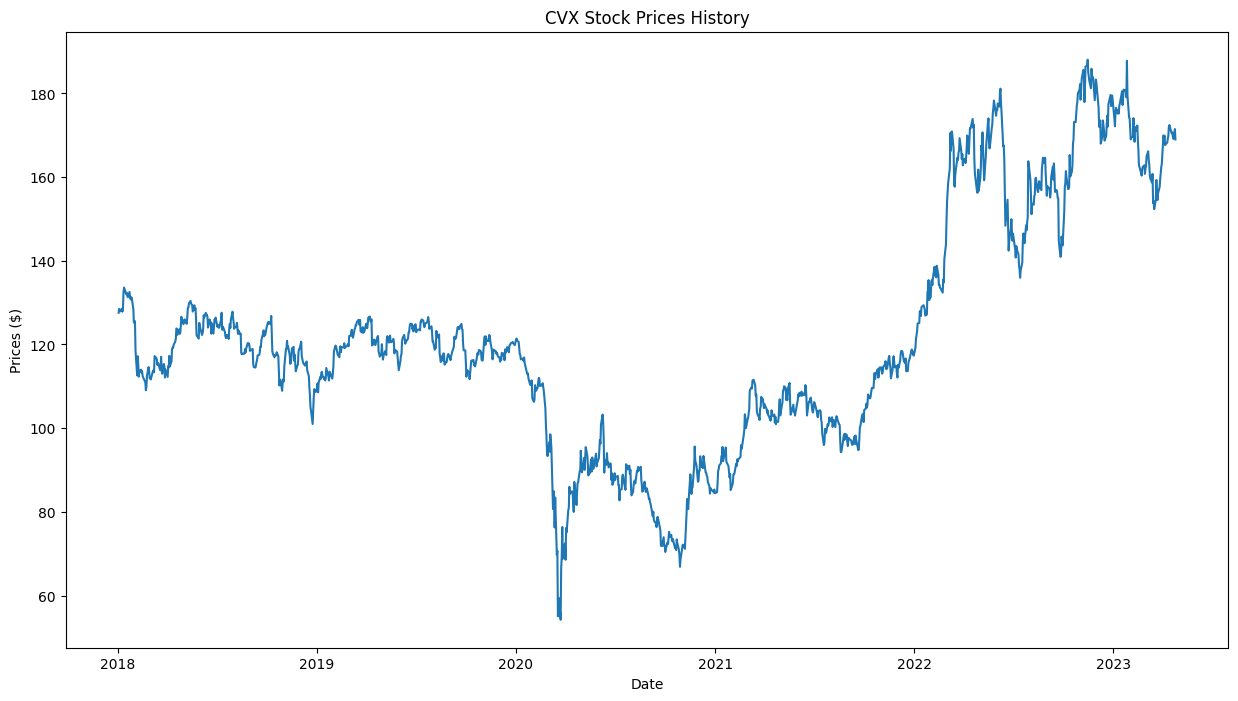

In [92]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

plt.figure(figsize=(15, 8))
plt.title('CVX Stock Prices History')
plt.plot(data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

**DATA PREPROCESSING**



*   Normalize data using the MinMaxScaler method




In [93]:
close_prices = data['Close']
values = close_prices.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))



*   Split data into train, test, and validation sets with a ratio of 7:2:1




In [94]:
train_size = int(len(scaled_data) * 0.7)
test_size = int(len(scaled_data) * 0.2)
val_size = len(scaled_data) - train_size - test_size

time_step = 60
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size-time_step:train_size+test_size, :]
val_data = scaled_data[train_size+test_size-time_step:, :]

In [95]:
print("Dataset size: ", len(values), "\n")

print("Train size: ", train_size)
print("Test size: ", test_size)
print("Valate size: ", val_size)

Dataset size:  1337 

Train size:  935
Test size:  267
Valate size:  135




*   Define the Create Dataset function


In [96]:
def create_dataset(dataset, time_step):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----59   Y=60
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)



*   Create train, test, and validation datasets



In [97]:
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)



*   Reshape train, test, and validation data (required for LSTM)



In [98]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

**BUILD GRU MODEL**

In [99]:
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [100]:
model.fit(X_train,y_train,epochs=50,batch_size=32,verbose=1)

Epoch 1/50
28/28 [==============================] - 2s 20ms/step - loss: 0.0279
Epoch 2/50
28/28 [==============================] - 1s 20ms/step - loss: 0.0029
Epoch 3/50
28/28 [==============================] - 1s 22ms/step - loss: 0.0017
Epoch 4/50
28/28 [==============================] - 1s 28ms/step - loss: 0.0011
Epoch 5/50
28/28 [==============================] - 1s 28ms/step - loss: 7.0547e-04
Epoch 6/50
28/28 [==============================] - 1s 22ms/step - loss: 5.2285e-04
Epoch 7/50
28/28 [==============================] - 1s 21ms/step - loss: 4.4287e-04
Epoch 8/50
28/28 [==============================] - 1s 20ms/step - loss: 4.1960e-04
Epoch 9/50
28/28 [==============================] - 1s 21ms/step - loss: 4.0922e-04
Epoch 10/50
28/28 [==============================] - 1s 19ms/step - loss: 4.0097e-04
Epoch 11/50
28/28 [==============================] - 1s 21ms/step - loss: 3.8408e-04
Epoch 12/50
28/28 [==============================] - 1s 20ms/step - loss: 3.7518e-04
Epoch



*   PLotting loss, it shows that loss has decreased significantly and model trained well



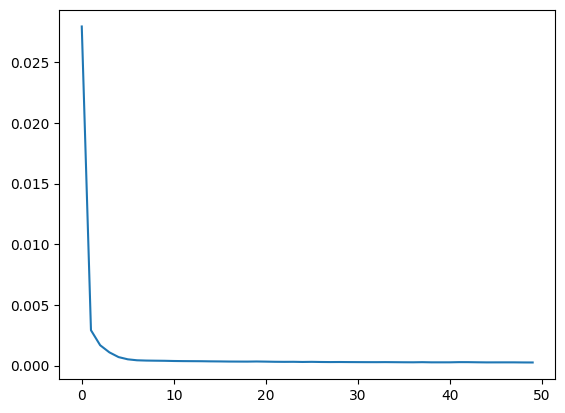

In [101]:
loss = model.history.history['loss']
plt.plot(loss)

**PREDICTION AND EVALUATION ON TEST/VAL DATA**



*   Make predictions on test and validation data



In [102]:
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

5/5 [==============================] - 0s 5ms/step




*   Convert the predictions back to the original values



In [103]:
y_pred=scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

y_pred_val=scaler.inverse_transform(y_pred_val)
y_val = scaler.inverse_transform(y_val.reshape(-1, 1))



*   Evaluate the algorithm's accuracy using RMSE, MAPE, MDA



In [104]:
# MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Using RMSE, MAPE và MDA
valid_rmse = np.sqrt(np.mean((y_val- y_pred_val) ** 2))
test_rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))

valid_mape = calculate_mape(y_val, y_pred_val)
test_mape = calculate_mape(y_test, y_pred)

valid_mda = calculate_mda(np.squeeze(y_val), np.squeeze(y_pred_val)) # Squeeze y_val and y_pred_val to 1D arrays
test_mda = calculate_mda(np.squeeze(y_test), np.squeeze(y_pred)) # Squeeze y_test and y_pred to 1D arrays

# Print results
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
print('Validation MDA:', valid_mda)
print('Testing MDA:', test_mda)

Validation RMSE: 2.9461576771895293
Testing RMSE: 3.205323684816161
Validation MAPE: 1.296005173052724
Testing MAPE: 1.5929995176200171
Validation MDA: 53.73134328358209
Testing MDA: 52.255639097744364


**FORECAST FOR THE NEXT 30 DAYS IN THE FUTURE**

In [105]:
n_days = 30

x_input=scaled_data[-time_step:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
i=0
while(i<n_days):

    if(len(temp_input)>time_step):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, time_step,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.8672071]
61
1 day input [0.89516552 0.87528953 0.8577299  0.86101767 0.86243739 0.89568851
 0.86512738 0.85347082 0.87984755 0.87267423 0.88246286 0.8577299
 0.8394979  0.81170144 0.79787789 0.79302102 0.80482695 0.80841367
 0.81147728 0.79615932 0.80572368 0.80953445 0.82746772 0.83650897
 0.82051854 0.81274753 0.79421649 0.78793989 0.78076668 0.79608453
 0.74407831 0.7477396  0.7331689  0.74990659 0.78524991 0.76104016
 0.74945828 0.76096537 0.77284608 0.78659495 0.79683179 0.80826419
 0.81401779 0.86475375 0.85795405 0.86423076 0.84756774 0.85234992
 0.8592991  0.86378244 0.88074418 0.88335948 0.87200176 0.86901294
 0.8702084  0.8640066  0.85855184 0.87618616 0.85758053 0.86720711]
1 day output [[0.8711079]]
2 day input [0.87528953 0.8577299  0.86101767 0.86243739 0.89568851 0.86512738
 0.85347082 0.87984755 0.87267423 0.88246286 0.8577299  0.8394979
 0.81170144 0.79787789 0.79302102 0.80482695 0.80841367 0.81147728
 0.79615932 0.80572368 0.80953445 0.82746772 0.83650897 0.820518



*   List of predicted stock prices for the next 30 days



In [106]:
for i in range(1, n_days+1):
    print(f"Ngày thứ {i}: {scaler.inverse_transform(lst_output)[i-1]}")
    # scaler.inverse_transform(lst_output)

Ngày thứ 1: [170.27833026]
Ngày thứ 2: [170.80036983]
Ngày thứ 3: [171.35730829]
Ngày thứ 4: [171.94944877]
Ngày thứ 5: [172.56273598]
Ngày thứ 6: [173.19728958]
Ngày thứ 7: [173.85271871]
Ngày thứ 8: [174.52986092]
Ngày thứ 9: [175.22842109]
Ngày thứ 10: [175.94855076]
Ngày thứ 11: [176.69101572]
Ngày thứ 12: [177.45606326]
Ngày thứ 13: [178.24458679]
Ngày thứ 14: [179.05697717]
Ngày thứ 15: [179.8939284]
Ngày thứ 16: [180.75577549]
Ngày thứ 17: [181.64308482]
Ngày thứ 18: [182.55640679]
Ngày thứ 19: [183.49669862]
Ngày thứ 20: [184.46471812]
Ngày thứ 21: [185.46145442]
Ngày thứ 22: [186.48735423]
Ngày thứ 23: [187.5435742]
Ngày thứ 24: [188.63080034]
Ngày thứ 25: [189.75045254]
Ngày thứ 26: [190.90389484]
Ngày thứ 27: [192.09213233]
Ngày thứ 28: [193.316553]
Ngày thứ 29: [194.57820979]
Ngày thứ 30: [195.87855449]


**VISUALIZATION OF PREDICTIONS**



*   Plot 1



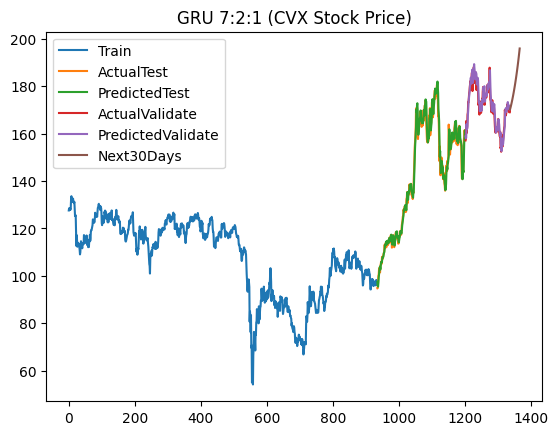

In [107]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
prediect_data_index = pd.RangeIndex(start=len(close_prices), stop=len(close_prices)+n_days, step=1)

plt.plot(scaler.inverse_transform(train_data))

plt.plot(test_data_index,y_test)
plt.plot(test_data_index,y_pred)

plt.plot(val_data_index,y_val)
plt.plot(val_data_index,y_pred_val)

plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.title('GRU 7:2:1 (CVX Stock Price)')
plt.legend(['Train','ActualTest','PredictedTest','ActualValidate','PredictedValidate','Next30Days'])
plt.show()



*   Plot 2



In [108]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data_index, y=scaler.inverse_transform(train_data)[:, 0], mode='lines+markers', marker=dict(size=4),  name='Train', marker_color='#1F77B4'))
fig.add_trace(go.Scatter(x=test_data_index,y=y_test[:, 0], mode='lines+markers', marker=dict(size=4), name='ActualTest', marker_color='#FF7F0E'))
fig.add_trace(go.Scatter(x=test_data_index,y=y_pred[:, 0], mode='lines+markers', marker=dict(size=4), name='PredictedTest', marker_color='#2CA02C'))
fig.add_trace(go.Scatter(x=val_data_index, y=y_val[:, 0], mode='lines+markers', marker=dict(size=4), name='ActualValidate', marker_color='#D62728'))
fig.add_trace(go.Scatter(x=val_data_index, y=y_pred_val[:, 0], mode='lines+markers', marker=dict(size=4), name='PredictedValidate', marker_color='#9569BE'))
fig.add_trace(go.Scatter(x=prediect_data_index, y=scaler.inverse_transform(lst_output)[:, 0], mode='lines+markers', marker=dict(size=4), name='Next30Days', marker_color='#000000'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'GRU 7:2:1 (CVX Stock Price)', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()



*   Plot 3



In [109]:
prediect_index = pd.RangeIndex(start=1, stop=1+n_days, step=1)

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=prediect_index, y=scaler.inverse_transform(lst_output)[:, 0], mode='lines+markers', marker=dict(size=4), name='Next30Days', marker_color='#FF7F0E'))
for i in range(len(prediect_index)):
  fig2.add_annotation(
      x=prediect_index[i],
      y=scaler.inverse_transform(lst_output)[i, 0],
      text=f"{scaler.inverse_transform(lst_output)[i, 0]:.2f}",
      showarrow=False,
      font=dict(color='black'),
      align='center',
      yshift=10)

fig2.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'GRU Prediction 7:2:1 (CVX Stock Price)', title_x = 0.5,
                  xaxis_title="Day",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig2.show()

# CVX 6-2-2

**DATA PREPARATION**



*   Import Packages



In [110]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense, GRU



*   Read data from a CSV file



In [111]:
data = pd.read_csv('/content/CVX.csv')

In [112]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,125.709999,127.739998,125.540001,127.580002,100.577354,5626000
1,2018-01-03,127.459999,128.940002,126.900002,128.509995,101.310501,5805500
2,2018-01-04,127.949997,128.350006,127.220001,128.110001,100.995163,4598300
3,2018-01-05,127.970001,128.100006,127.099998,127.900002,100.829620,4189200
4,2018-01-08,127.860001,128.630005,127.629997,128.529999,101.326271,4826100




*   Visualize the stock price history


Text(0, 0.5, 'Prices ($)')

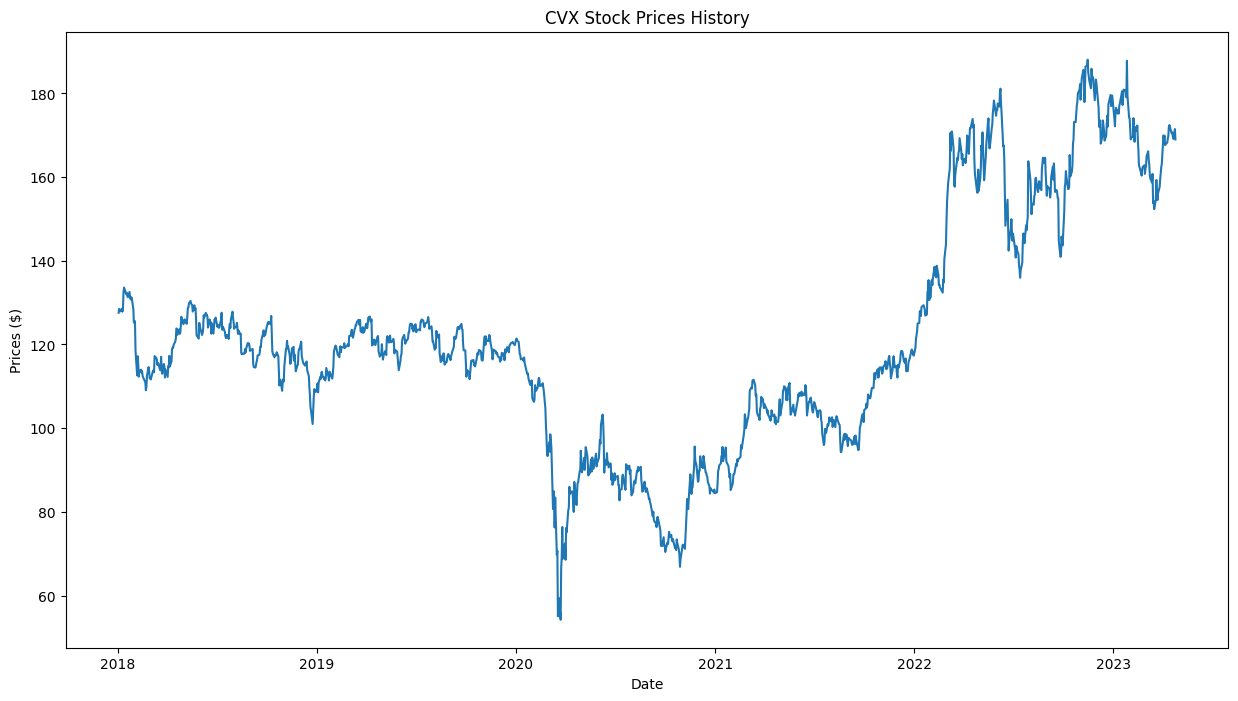

In [113]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

plt.figure(figsize=(15, 8))
plt.title('CVX Stock Prices History')
plt.plot(data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

**DATA PREPROCESSING**



*   Normalize data using the MinMaxScaler method




In [114]:
close_prices = data['Close']
values = close_prices.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))



*   Split data into train, test, and validation sets with a ratio of 6:2:2




In [115]:
train_size = int(len(scaled_data) * 0.6)
test_size = int(len(scaled_data) * 0.2)
val_size = len(scaled_data) - train_size - test_size

time_step = 60
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size-time_step:train_size+test_size, :]
val_data = scaled_data[train_size+test_size-time_step:, :]

In [116]:
print("Dataset size: ", len(values), "\n")

print("Train size: ", train_size)
print("Test size: ", test_size)
print("Valate size: ", val_size)

Dataset size:  1337 

Train size:  802
Test size:  267
Valate size:  268




*   Define the Create Dataset function


In [117]:
def create_dataset(dataset, time_step):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----59   Y=60
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)



*   Create train, test, and validation datasets



In [118]:
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)



*   Reshape train, test, and validation data (required for LSTM)



In [119]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

**BUILD GRU MODEL**

In [120]:
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [121]:
model.fit(X_train,y_train,epochs=50,batch_size=32,verbose=1)

Epoch 1/50
24/24 [==============================] - 2s 19ms/step - loss: 0.0365
Epoch 2/50
24/24 [==============================] - 0s 21ms/step - loss: 0.0040
Epoch 3/50
24/24 [==============================] - 0s 20ms/step - loss: 0.0023
Epoch 4/50
24/24 [==============================] - 0s 20ms/step - loss: 0.0015
Epoch 5/50
24/24 [==============================] - 0s 20ms/step - loss: 9.4683e-04
Epoch 6/50
24/24 [==============================] - 1s 29ms/step - loss: 6.2993e-04
Epoch 7/50
24/24 [==============================] - 1s 28ms/step - loss: 5.1347e-04
Epoch 8/50
24/24 [==============================] - 1s 27ms/step - loss: 4.7752e-04
Epoch 9/50
24/24 [==============================] - 0s 20ms/step - loss: 4.6775e-04
Epoch 10/50
24/24 [==============================] - 0s 21ms/step - loss: 4.5966e-04
Epoch 11/50
24/24 [==============================] - 1s 21ms/step - loss: 4.5855e-04
Epoch 12/50
24/24 [==============================] - 0s 20ms/step - loss: 4.4683e-04
Epoch



*   PLotting loss, it shows that loss has decreased significantly and model trained well



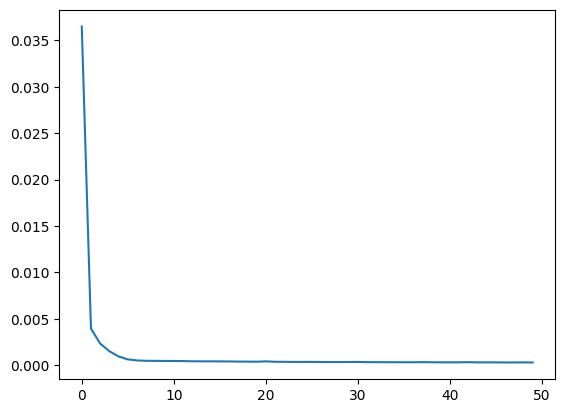

In [122]:
loss = model.history.history['loss']
plt.plot(loss)

**PREDICTION AND EVALUATION ON TEST/VAL DATA**



*   Make predictions on test and validation data



In [123]:
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

9/9 [==============================] - 0s 5ms/step




*   Convert the predictions back to the original values



In [124]:
y_pred=scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

y_pred_val=scaler.inverse_transform(y_pred_val)
y_val = scaler.inverse_transform(y_val.reshape(-1, 1))



*   Evaluate the algorithm's accuracy using RMSE, MAPE, MDA



In [125]:
# MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Using RMSE, MAPE và MDA
valid_rmse = np.sqrt(np.mean((y_val- y_pred_val) ** 2))
test_rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))

valid_mape = calculate_mape(y_val, y_pred_val)
test_mape = calculate_mape(y_test, y_pred)

valid_mda = calculate_mda(np.squeeze(y_val), np.squeeze(y_pred_val)) # Squeeze y_val and y_pred_val to 1D arrays
test_mda = calculate_mda(np.squeeze(y_test), np.squeeze(y_pred)) # Squeeze y_test and y_pred to 1D arrays

# Print results
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
print('Validation MDA:', valid_mda)
print('Testing MDA:', test_mda)

Validation RMSE: 3.5623142392267613
Testing RMSE: 2.2631846276230054
Validation MAPE: 1.6960488511924194
Testing MAPE: 1.4396141193806358
Validation MDA: 49.063670411985015
Testing MDA: 47.368421052631575


**FORECAST FOR THE NEXT 30 DAYS IN THE FUTURE**

In [126]:
n_days = 30

x_input=scaled_data[-time_step:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
i=0
while(i<n_days):

    if(len(temp_input)>time_step):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, time_step,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.8562875]
61
1 day input [0.89516552 0.87528953 0.8577299  0.86101767 0.86243739 0.89568851
 0.86512738 0.85347082 0.87984755 0.87267423 0.88246286 0.8577299
 0.8394979  0.81170144 0.79787789 0.79302102 0.80482695 0.80841367
 0.81147728 0.79615932 0.80572368 0.80953445 0.82746772 0.83650897
 0.82051854 0.81274753 0.79421649 0.78793989 0.78076668 0.79608453
 0.74407831 0.7477396  0.7331689  0.74990659 0.78524991 0.76104016
 0.74945828 0.76096537 0.77284608 0.78659495 0.79683179 0.80826419
 0.81401779 0.86475375 0.85795405 0.86423076 0.84756774 0.85234992
 0.8592991  0.86378244 0.88074418 0.88335948 0.87200176 0.86901294
 0.8702084  0.8640066  0.85855184 0.87618616 0.85758053 0.85628748]
1 day output [[0.85152817]]
2 day input [0.87528953 0.8577299  0.86101767 0.86243739 0.89568851 0.86512738
 0.85347082 0.87984755 0.87267423 0.88246286 0.8577299  0.8394979
 0.81170144 0.79787789 0.79302102 0.80482695 0.80841367 0.81147728
 0.79615932 0.80572368 0.80953445 0.82746772 0.83650897 0.82051



*   List of predicted stock prices for the next 30 days



In [127]:
for i in range(1, n_days+1):
    print(f"Ngày thứ {i}: {scaler.inverse_transform(lst_output)[i-1]}")
    # scaler.inverse_transform(lst_output)

Ngày thứ 1: [168.81695608]
Ngày thứ 2: [168.18001739]
Ngày thứ 3: [167.5253381]
Ngày thứ 4: [166.84482963]
Ngày thứ 5: [166.14215339]
Ngày thứ 6: [165.41947909]
Ngày thứ 7: [164.67841806]
Ngày thứ 8: [163.92169839]
Ngày thứ 9: [163.14934402]
Ngày thứ 10: [162.36242385]
Ngày thứ 11: [161.56291614]
Ngày thứ 12: [160.75160264]
Ngày thứ 13: [159.93028612]
Ngày thứ 14: [159.0994771]
Ngày thứ 15: [158.26022056]
Ngày thứ 16: [157.41290736]
Ngày thứ 17: [156.55818362]
Ngày thứ 18: [155.69683907]
Ngày thứ 19: [154.82999046]
Ngày thứ 20: [153.95850728]
Ngày thứ 21: [153.08327496]
Ngày thứ 22: [152.204469]
Ngày thứ 23: [151.32318222]
Ngày thứ 24: [150.43995706]
Ngày thứ 25: [149.55612565]
Ngày thứ 26: [148.67270107]
Ngày thứ 27: [147.79009811]
Ngày thứ 28: [146.90917827]
Ngày thứ 29: [146.03032444]
Ngày thứ 30: [145.15430241]


**VISUALIZATION OF PREDICTIONS**



*   Plot 1



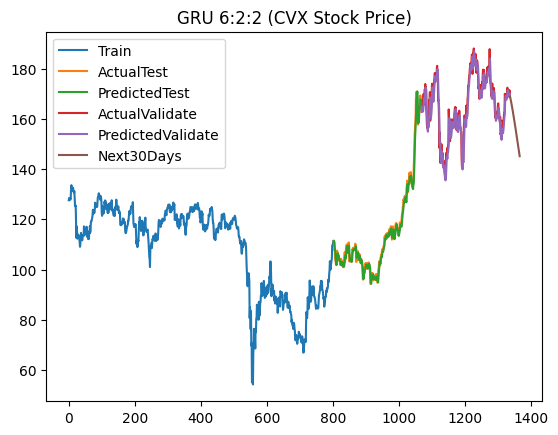

In [128]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
prediect_data_index = pd.RangeIndex(start=len(close_prices), stop=len(close_prices)+n_days, step=1)

plt.plot(scaler.inverse_transform(train_data))

plt.plot(test_data_index,y_test)
plt.plot(test_data_index,y_pred)

plt.plot(val_data_index,y_val)
plt.plot(val_data_index,y_pred_val)

plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.title('GRU 6:2:2 (CVX Stock Price)')
plt.legend(['Train','ActualTest','PredictedTest','ActualValidate','PredictedValidate','Next30Days'])
plt.show()



*   Plot 2



In [129]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data_index, y=scaler.inverse_transform(train_data)[:, 0], mode='lines+markers', marker=dict(size=4),  name='Train', marker_color='#1F77B4'))
fig.add_trace(go.Scatter(x=test_data_index,y=y_test[:, 0], mode='lines+markers', marker=dict(size=4), name='ActualTest', marker_color='#FF7F0E'))
fig.add_trace(go.Scatter(x=test_data_index,y=y_pred[:, 0], mode='lines+markers', marker=dict(size=4), name='PredictedTest', marker_color='#2CA02C'))
fig.add_trace(go.Scatter(x=val_data_index, y=y_val[:, 0], mode='lines+markers', marker=dict(size=4), name='ActualValidate', marker_color='#D62728'))
fig.add_trace(go.Scatter(x=val_data_index, y=y_pred_val[:, 0], mode='lines+markers', marker=dict(size=4), name='PredictedValidate', marker_color='#9569BE'))
fig.add_trace(go.Scatter(x=prediect_data_index, y=scaler.inverse_transform(lst_output)[:, 0], mode='lines+markers', marker=dict(size=4), name='Next30Days', marker_color='#000000'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'GRU 6:2:2 (CVX Stock Price)', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()



*   Plot 3



In [130]:
prediect_index = pd.RangeIndex(start=1, stop=1+n_days, step=1)

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=prediect_index, y=scaler.inverse_transform(lst_output)[:, 0], mode='lines+markers', marker=dict(size=4), name='Next30Days', marker_color='#FF7F0E'))
for i in range(len(prediect_index)):
  fig2.add_annotation(
      x=prediect_index[i],
      y=scaler.inverse_transform(lst_output)[i, 0],
      text=f"{scaler.inverse_transform(lst_output)[i, 0]:.2f}",
      showarrow=False,
      font=dict(color='black'),
      align='center',
      yshift=10)

fig2.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'GRU Prediction 6:2:2 (CVX Stock Price)', title_x = 0.5,
                  xaxis_title="Day",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig2.show()

# VLO 7-2-1

**DATA PREPARATION**



*   Import Packages



In [131]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense, GRU



*   Read data from a CSV file



In [132]:
data = pd.read_csv('/content/VLO.csv')

In [133]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,92.190002,93.139999,91.709999,92.800003,72.733238,3582900
1,2018-01-03,92.580002,93.470001,92.500000,93.290001,73.117294,3057600
2,2018-01-04,93.410004,93.620003,92.639999,93.589996,73.352425,2977000
3,2018-01-05,93.599998,94.300003,93.430000,94.029999,73.697281,2973800
4,2018-01-08,94.129997,94.370003,93.400002,94.220001,73.846207,2493400




*   Visualize the stock price history


Text(0, 0.5, 'Prices ($)')

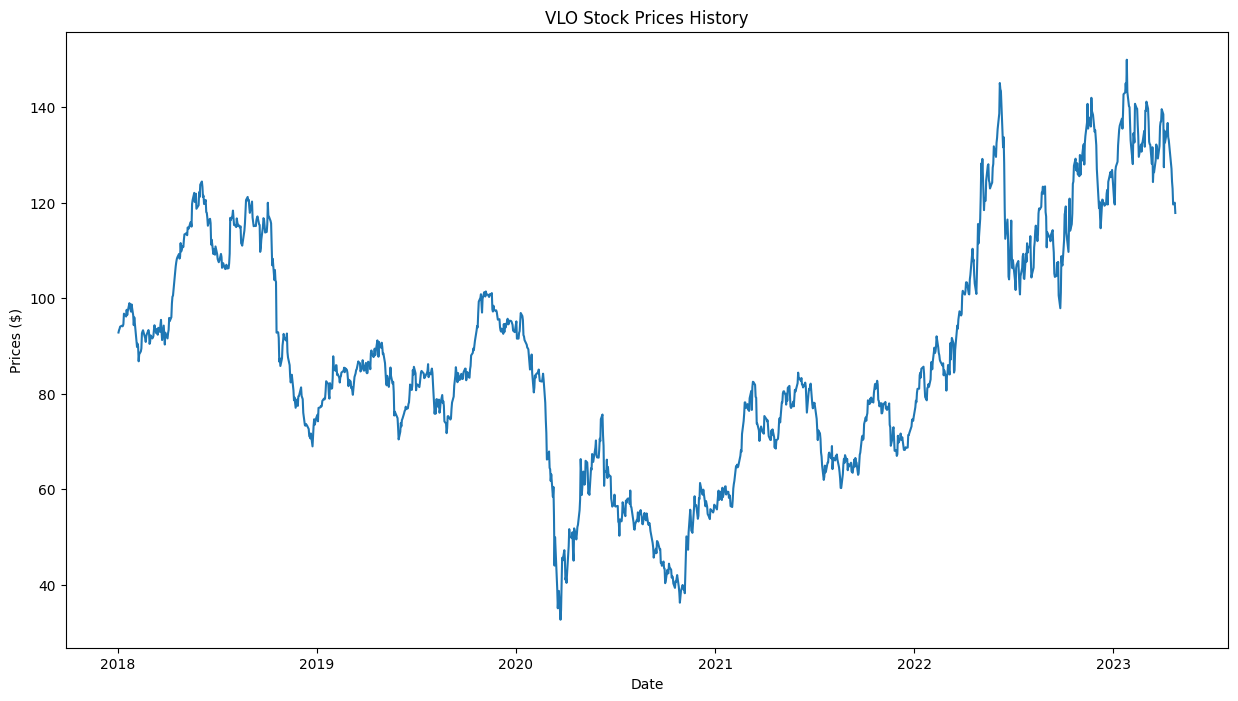

In [134]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

plt.figure(figsize=(15, 8))
plt.title('VLO Stock Prices History')
plt.plot(data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

**DATA PREPROCESSING**



*   Normalize data using the MinMaxScaler method




In [135]:
close_prices = data['Close']
values = close_prices.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))



*   Split data into train, test, and validation sets with a ratio of 7:2:1




In [136]:
train_size = int(len(scaled_data) * 0.7)
test_size = int(len(scaled_data) * 0.2)
val_size = len(scaled_data) - train_size - test_size

time_step = 60
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size-time_step:train_size+test_size, :]
val_data = scaled_data[train_size+test_size-time_step:, :]

In [137]:
print("Dataset size: ", len(values), "\n")

print("Train size: ", train_size)
print("Test size: ", test_size)
print("Valate size: ", val_size)

Dataset size:  1337 

Train size:  935
Test size:  267
Valate size:  135




*   Define the Create Dataset function


In [138]:
def create_dataset(dataset, time_step):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----59   Y=60
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)



*   Create train, test, and validation datasets



In [139]:
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)



*   Reshape train, test, and validation data (required for LSTM)



In [140]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

**BUILD GRU MODEL**

In [141]:
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [142]:
model.fit(X_train,y_train,epochs=50,batch_size=32,verbose=1)

Epoch 1/50
28/28 [==============================] - 2s 20ms/step - loss: 0.0239
Epoch 2/50
28/28 [==============================] - 1s 20ms/step - loss: 0.0031
Epoch 3/50
28/28 [==============================] - 1s 20ms/step - loss: 0.0011
Epoch 4/50
28/28 [==============================] - 1s 21ms/step - loss: 6.2075e-04
Epoch 5/50
28/28 [==============================] - 1s 21ms/step - loss: 5.7062e-04
Epoch 6/50
28/28 [==============================] - 1s 20ms/step - loss: 5.4103e-04
Epoch 7/50
28/28 [==============================] - 1s 21ms/step - loss: 5.2063e-04
Epoch 8/50
28/28 [==============================] - 1s 20ms/step - loss: 5.1033e-04
Epoch 9/50
28/28 [==============================] - 1s 20ms/step - loss: 4.8785e-04
Epoch 10/50
28/28 [==============================] - 1s 20ms/step - loss: 4.7672e-04
Epoch 11/50
28/28 [==============================] - 1s 20ms/step - loss: 4.6834e-04
Epoch 12/50
28/28 [==============================] - 1s 20ms/step - loss: 4.5702e-04
E



*   PLotting loss, it shows that loss has decreased significantly and model trained well



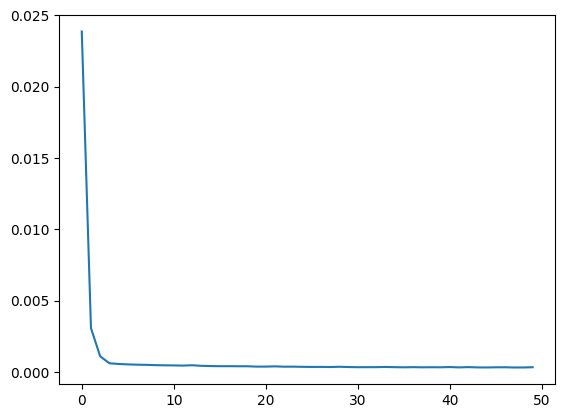

In [143]:
loss = model.history.history['loss']
plt.plot(loss)

**PREDICTION AND EVALUATION ON TEST/VAL DATA**



*   Make predictions on test and validation data



In [144]:
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

5/5 [==============================] - 0s 7ms/step




*   Convert the predictions back to the original values



In [145]:
y_pred=scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

y_pred_val=scaler.inverse_transform(y_pred_val)
y_val = scaler.inverse_transform(y_val.reshape(-1, 1))



*   Evaluate the algorithm's accuracy using RMSE, MAPE, MDA



In [146]:
# MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Using RMSE, MAPE và MDA
valid_rmse = np.sqrt(np.mean((y_val- y_pred_val) ** 2))
test_rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))

valid_mape = calculate_mape(y_val, y_pred_val)
test_mape = calculate_mape(y_test, y_pred)

valid_mda = calculate_mda(np.squeeze(y_val), np.squeeze(y_pred_val)) # Squeeze y_val and y_pred_val to 1D arrays
test_mda = calculate_mda(np.squeeze(y_test), np.squeeze(y_pred)) # Squeeze y_test and y_pred to 1D arrays

# Print results
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
print('Validation MDA:', valid_mda)
print('Testing MDA:', test_mda)

Validation RMSE: 3.5154783963308813
Testing RMSE: 3.160502405703422
Validation MAPE: 2.163832130916306
Testing MAPE: 2.3850537131851026
Validation MDA: 50.74626865671642
Testing MDA: 52.63157894736842


**FORECAST FOR THE NEXT 30 DAYS IN THE FUTURE**

In [147]:
n_days = 30

x_input=scaled_data[-time_step:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
i=0
while(i<n_days):

    if(len(temp_input)>time_step):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, time_step,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.7154787]
61
1 day input [0.91537406 0.88298952 0.85588885 0.84463943 0.81361846 0.86841655
 0.86500758 0.85222421 0.92133961 0.91341398 0.91247653 0.88418262
 0.86372929 0.82657231 0.84864489 0.83577634 0.85060497 0.85333215
 0.87293333 0.84463943 0.90906755 0.90855624 0.92508941 0.91247653
 0.88921085 0.85350263 0.84932668 0.84830406 0.81378895 0.84370197
 0.78157488 0.80577802 0.79896027 0.82060677 0.84855971 0.84498038
 0.83313448 0.82358948 0.84591784 0.88119991 0.88912554 0.88972216
 0.91170956 0.9025907  0.80799382 0.87327416 0.85196855 0.87335947
 0.88708029 0.86159873 0.85657064 0.84574736 0.81540819 0.80526671
 0.78217144 0.76981415 0.7415203  0.74467356 0.72635072 0.71547872]
1 day output [[0.7033292]]
2 day input [0.88298952 0.85588885 0.84463943 0.81361846 0.86841655 0.86500758
 0.85222421 0.92133961 0.91341398 0.91247653 0.88418262 0.86372929
 0.82657231 0.84864489 0.83577634 0.85060497 0.85333215 0.87293333
 0.84463943 0.90906755 0.90855624 0.92508941 0.91247653 0.8892



*   List of predicted stock prices for the next 30 days



In [148]:
for i in range(1, n_days+1):
    print(f"Ngày thứ {i}: {scaler.inverse_transform(lst_output)[i-1]}")
    # scaler.inverse_transform(lst_output)

Ngày thứ 1: [116.57427753]
Ngày thứ 2: [115.1486536]
Ngày thứ 3: [113.72377104]
Ngày thứ 4: [112.29025787]
Ngày thứ 5: [110.84737273]
Ngày thứ 6: [109.39601785]
Ngày thứ 7: [107.93331168]
Ngày thứ 8: [106.46424796]
Ngày thứ 9: [104.98875675]
Ngày thứ 10: [103.50561409]
Ngày thứ 11: [102.02071594]
Ngày thứ 12: [100.53499249]
Ngày thứ 13: [99.05201768]
Ngày thứ 14: [97.573568]
Ngày thứ 15: [96.10223823]
Ngày thứ 16: [94.63811228]
Ngày thứ 17: [93.18521172]
Ngày thứ 18: [91.74434784]
Ngày thứ 19: [90.3183952]
Ngày thứ 20: [88.90909529]
Ngày thứ 21: [87.51957445]
Ngày thứ 22: [86.14910528]
Ngày thứ 23: [84.80230384]
Ngày thứ 24: [83.48022273]
Ngày thứ 25: [82.18574697]
Ngày thứ 26: [80.92076845]
Ngày thứ 27: [79.68696223]
Ngày thứ 28: [78.48499973]
Ngày thứ 29: [77.31641965]
Ngày thứ 30: [76.18263475]


**VISUALIZATION OF PREDICTIONS**



*   Plot 1



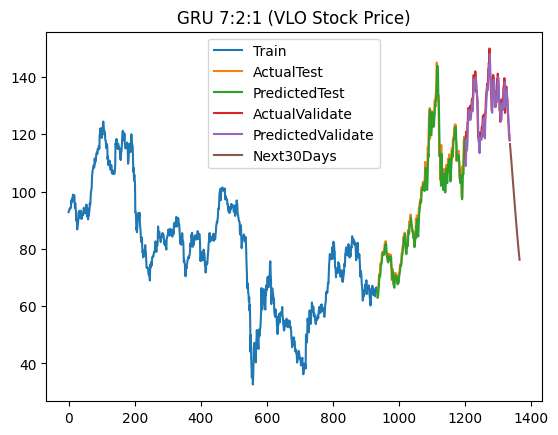

In [149]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
prediect_data_index = pd.RangeIndex(start=len(close_prices), stop=len(close_prices)+n_days, step=1)

plt.plot(scaler.inverse_transform(train_data))

plt.plot(test_data_index,y_test)
plt.plot(test_data_index,y_pred)

plt.plot(val_data_index,y_val)
plt.plot(val_data_index,y_pred_val)

plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.title('GRU 7:2:1 (VLO Stock Price)')
plt.legend(['Train','ActualTest','PredictedTest','ActualValidate','PredictedValidate','Next30Days'])
plt.show()



*   Plot 2



In [150]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data_index, y=scaler.inverse_transform(train_data)[:, 0], mode='lines+markers', marker=dict(size=4),  name='Train', marker_color='#1F77B4'))
fig.add_trace(go.Scatter(x=test_data_index,y=y_test[:, 0], mode='lines+markers', marker=dict(size=4), name='ActualTest', marker_color='#FF7F0E'))
fig.add_trace(go.Scatter(x=test_data_index,y=y_pred[:, 0], mode='lines+markers', marker=dict(size=4), name='PredictedTest', marker_color='#2CA02C'))
fig.add_trace(go.Scatter(x=val_data_index, y=y_val[:, 0], mode='lines+markers', marker=dict(size=4), name='ActualValidate', marker_color='#D62728'))
fig.add_trace(go.Scatter(x=val_data_index, y=y_pred_val[:, 0], mode='lines+markers', marker=dict(size=4), name='PredictedValidate', marker_color='#9569BE'))
fig.add_trace(go.Scatter(x=prediect_data_index, y=scaler.inverse_transform(lst_output)[:, 0], mode='lines+markers', marker=dict(size=4), name='Next30Days', marker_color='#000000'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'GRU 7:2:1 (VLO Stock Price)', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()



*   Plot 3



In [151]:
prediect_index = pd.RangeIndex(start=1, stop=1+n_days, step=1)

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=prediect_index, y=scaler.inverse_transform(lst_output)[:, 0], mode='lines+markers', marker=dict(size=4), name='Next30Days', marker_color='#FF7F0E'))
for i in range(len(prediect_index)):
  fig2.add_annotation(
      x=prediect_index[i],
      y=scaler.inverse_transform(lst_output)[i, 0],
      text=f"{scaler.inverse_transform(lst_output)[i, 0]:.2f}",
      showarrow=False,
      font=dict(color='black'),
      align='center',
      yshift=10)

fig2.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'GRU Prediction 7:2:1 (VLO Stock Price)', title_x = 0.5,
                  xaxis_title="Day",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig2.show()

# VLO 6-2-2

**DATA PREPARATION**



*   Import Packages



In [152]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense, GRU



*   Read data from a CSV file



In [153]:
data = pd.read_csv('/content/VLO.csv')

In [154]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,92.190002,93.139999,91.709999,92.800003,72.733238,3582900
1,2018-01-03,92.580002,93.470001,92.500000,93.290001,73.117294,3057600
2,2018-01-04,93.410004,93.620003,92.639999,93.589996,73.352425,2977000
3,2018-01-05,93.599998,94.300003,93.430000,94.029999,73.697281,2973800
4,2018-01-08,94.129997,94.370003,93.400002,94.220001,73.846207,2493400




*   Visualize the stock price history


Text(0, 0.5, 'Prices ($)')

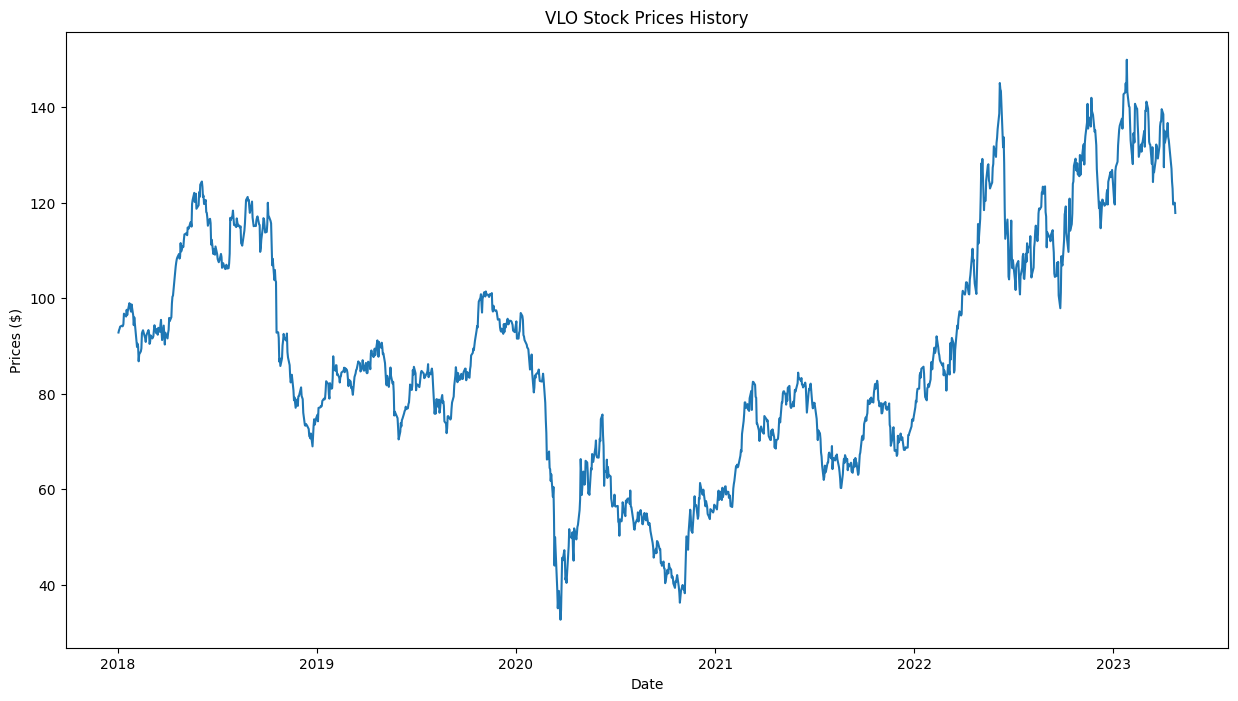

In [155]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

plt.figure(figsize=(15, 8))
plt.title('VLO Stock Prices History')
plt.plot(data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

**DATA PREPROCESSING**



*   Normalize data using the MinMaxScaler method




In [156]:
close_prices = data['Close']
values = close_prices.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))



*   Split data into train, test, and validation sets with a ratio of 6:2:2




In [157]:
train_size = int(len(scaled_data) * 0.6)
test_size = int(len(scaled_data) * 0.2)
val_size = len(scaled_data) - train_size - test_size

time_step = 60
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size-time_step:train_size+test_size, :]
val_data = scaled_data[train_size+test_size-time_step:, :]

In [158]:
print("Dataset size: ", len(values), "\n")

print("Train size: ", train_size)
print("Test size: ", test_size)
print("Valate size: ", val_size)

Dataset size:  1337 

Train size:  802
Test size:  267
Valate size:  268




*   Define the Create Dataset function


In [159]:
def create_dataset(dataset, time_step):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----59   Y=60
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)



*   Create train, test, and validation datasets



In [160]:
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)



*   Reshape train, test, and validation data (required for LSTM)



In [161]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

**BUILD GRU MODEL**

In [162]:
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [163]:
model.fit(X_train,y_train,epochs=50,batch_size=32,verbose=1)

Epoch 1/50
24/24 [==============================] - 2s 21ms/step - loss: 0.0773
Epoch 2/50
24/24 [==============================] - 1s 21ms/step - loss: 0.0091
Epoch 3/50
24/24 [==============================] - 1s 21ms/step - loss: 0.0046
Epoch 4/50
24/24 [==============================] - 0s 20ms/step - loss: 0.0019
Epoch 5/50
24/24 [==============================] - 1s 21ms/step - loss: 9.1654e-04
Epoch 6/50
24/24 [==============================] - 0s 20ms/step - loss: 7.6901e-04
Epoch 7/50
24/24 [==============================] - 0s 21ms/step - loss: 7.3556e-04
Epoch 8/50
24/24 [==============================] - 0s 20ms/step - loss: 6.9846e-04
Epoch 9/50
24/24 [==============================] - 0s 21ms/step - loss: 6.8610e-04
Epoch 10/50
24/24 [==============================] - 0s 20ms/step - loss: 6.5307e-04
Epoch 11/50
24/24 [==============================] - 1s 21ms/step - loss: 6.3231e-04
Epoch 12/50
24/24 [==============================] - 1s 21ms/step - loss: 6.1711e-04
Epoch



*   PLotting loss, it shows that loss has decreased significantly and model trained well



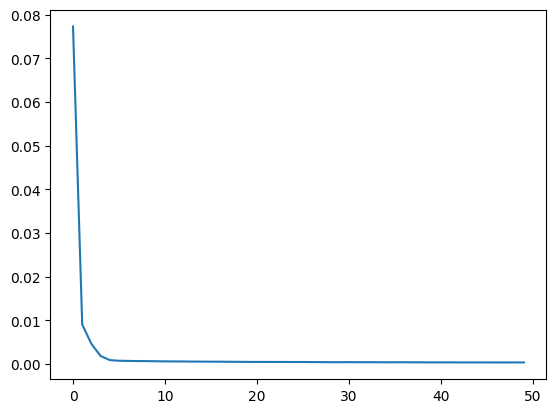

In [164]:
loss = model.history.history['loss']
plt.plot(loss)

**PREDICTION AND EVALUATION ON TEST/VAL DATA**



*   Make predictions on test and validation data



In [165]:
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

9/9 [==============================] - 0s 5ms/step




*   Convert the predictions back to the original values



In [166]:
y_pred=scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

y_pred_val=scaler.inverse_transform(y_pred_val)
y_val = scaler.inverse_transform(y_val.reshape(-1, 1))



*   Evaluate the algorithm's accuracy using RMSE, MAPE, MDA



In [167]:
# MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Using RMSE, MAPE và MDA
valid_rmse = np.sqrt(np.mean((y_val- y_pred_val) ** 2))
test_rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))

valid_mape = calculate_mape(y_val, y_pred_val)
test_mape = calculate_mape(y_test, y_pred)

valid_mda = calculate_mda(np.squeeze(y_val), np.squeeze(y_pred_val)) # Squeeze y_val and y_pred_val to 1D arrays
test_mda = calculate_mda(np.squeeze(y_test), np.squeeze(y_pred)) # Squeeze y_test and y_pred to 1D arrays

# Print results
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
print('Validation MDA:', valid_mda)
print('Testing MDA:', test_mda)

Validation RMSE: 3.773930752335042
Testing RMSE: 1.9691985636181215
Validation MAPE: 2.471206039389929
Testing MAPE: 2.056421433875881
Validation MDA: 55.430711610486895
Testing MDA: 53.383458646616546


**FORECAST FOR THE NEXT 30 DAYS IN THE FUTURE**

In [168]:
n_days = 30

x_input=scaled_data[-time_step:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
i=0
while(i<n_days):

    if(len(temp_input)>time_step):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, time_step,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.7230179]
61
1 day input [0.91537406 0.88298952 0.85588885 0.84463943 0.81361846 0.86841655
 0.86500758 0.85222421 0.92133961 0.91341398 0.91247653 0.88418262
 0.86372929 0.82657231 0.84864489 0.83577634 0.85060497 0.85333215
 0.87293333 0.84463943 0.90906755 0.90855624 0.92508941 0.91247653
 0.88921085 0.85350263 0.84932668 0.84830406 0.81378895 0.84370197
 0.78157488 0.80577802 0.79896027 0.82060677 0.84855971 0.84498038
 0.83313448 0.82358948 0.84591784 0.88119991 0.88912554 0.88972216
 0.91170956 0.9025907  0.80799382 0.87327416 0.85196855 0.87335947
 0.88708029 0.86159873 0.85657064 0.84574736 0.81540819 0.80526671
 0.78217144 0.76981415 0.7415203  0.74467356 0.72635072 0.72301787]
1 day output [[0.7157211]]
2 day input [0.88298952 0.85588885 0.84463943 0.81361846 0.86841655 0.86500758
 0.85222421 0.92133961 0.91341398 0.91247653 0.88418262 0.86372929
 0.82657231 0.84864489 0.83577634 0.85060497 0.85333215 0.87293333
 0.84463943 0.90906755 0.90855624 0.92508941 0.91247653 0.8892



*   List of predicted stock prices for the next 30 days



In [169]:
for i in range(1, n_days+1):
    print(f"Ngày thứ {i}: {scaler.inverse_transform(lst_output)[i-1]}")
    # scaler.inverse_transform(lst_output)

Ngày thứ 1: [117.45892181]
Ngày thứ 2: [116.60271517]
Ngày thứ 3: [115.83607381]
Ngày thứ 4: [115.11965644]
Ngày thứ 5: [114.43455824]
Ngày thứ 6: [113.77228849]
Ngày thứ 7: [113.12312551]
Ngày thứ 8: [112.49082508]
Ngày thứ 9: [111.86934439]
Ngày thứ 10: [111.253354]
Ngày thứ 11: [110.64950521]
Ngày thứ 12: [110.05418911]
Ngày thứ 13: [109.46881849]
Ngày thứ 14: [108.89157491]
Ngày thứ 15: [108.32202474]
Ngày thứ 16: [107.7562933]
Ngày thứ 17: [107.19730409]
Ngày thứ 18: [106.64196575]
Ngày thứ 19: [106.09124345]
Ngày thứ 20: [105.54404613]
Ngày thứ 21: [105.0014229]
Ngày thứ 22: [104.45833806]
Ngày thứ 23: [103.92040082]
Ngày thứ 24: [103.38541504]
Ngày thứ 25: [102.85571674]
Ngày thứ 26: [102.33125695]
Ngày thứ 27: [101.81195874]
Ngày thứ 28: [101.29633238]
Ngày thứ 29: [100.78555288]
Ngày thứ 30: [100.28025667]


**VISUALIZATION OF PREDICTIONS**



*   Plot 1



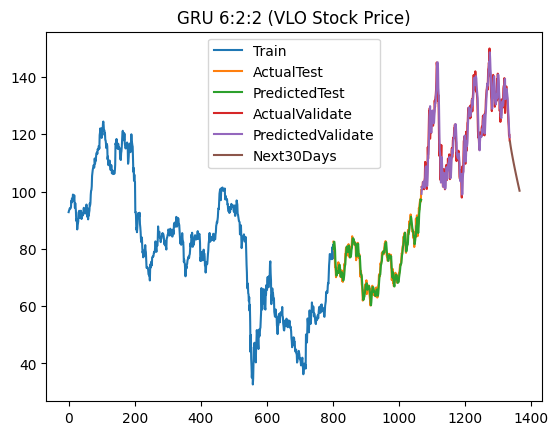

In [170]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
prediect_data_index = pd.RangeIndex(start=len(close_prices), stop=len(close_prices)+n_days, step=1)

plt.plot(scaler.inverse_transform(train_data))

plt.plot(test_data_index,y_test)
plt.plot(test_data_index,y_pred)

plt.plot(val_data_index,y_val)
plt.plot(val_data_index,y_pred_val)

plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.title('GRU 6:2:2 (VLO Stock Price)')
plt.legend(['Train','ActualTest','PredictedTest','ActualValidate','PredictedValidate','Next30Days'])
plt.show()



*   Plot 2



In [171]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data_index, y=scaler.inverse_transform(train_data)[:, 0], mode='lines+markers', marker=dict(size=4),  name='Train', marker_color='#1F77B4'))
fig.add_trace(go.Scatter(x=test_data_index,y=y_test[:, 0], mode='lines+markers', marker=dict(size=4), name='ActualTest', marker_color='#FF7F0E'))
fig.add_trace(go.Scatter(x=test_data_index,y=y_pred[:, 0], mode='lines+markers', marker=dict(size=4), name='PredictedTest', marker_color='#2CA02C'))
fig.add_trace(go.Scatter(x=val_data_index, y=y_val[:, 0], mode='lines+markers', marker=dict(size=4), name='ActualValidate', marker_color='#D62728'))
fig.add_trace(go.Scatter(x=val_data_index, y=y_pred_val[:, 0], mode='lines+markers', marker=dict(size=4), name='PredictedValidate', marker_color='#9569BE'))
fig.add_trace(go.Scatter(x=prediect_data_index, y=scaler.inverse_transform(lst_output)[:, 0], mode='lines+markers', marker=dict(size=4), name='Next30Days', marker_color='#000000'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'GRU 6:2:2 (VLO Stock Price)', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()



*   Plot 3



In [172]:
prediect_index = pd.RangeIndex(start=1, stop=1+n_days, step=1)

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=prediect_index, y=scaler.inverse_transform(lst_output)[:, 0], mode='lines+markers', marker=dict(size=4), name='Next30Days', marker_color='#FF7F0E'))
for i in range(len(prediect_index)):
  fig2.add_annotation(
      x=prediect_index[i],
      y=scaler.inverse_transform(lst_output)[i, 0],
      text=f"{scaler.inverse_transform(lst_output)[i, 0]:.2f}",
      showarrow=False,
      font=dict(color='black'),
      align='center',
      yshift=10)

fig2.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'GRU Prediction 6:2:2 (VLO Stock Price)', title_x = 0.5,
                  xaxis_title="Day",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig2.show()